<h1>Magnesium Pyrophosphate Solubility<h1>

In this notebook, we use our published model to make predictions about the solution thermodynamics of Magnesium Pyrophosphate solutions. 

<b>1. Importing required packages<b>

In [16]:
using Pkg
Pkg.activate("IVTmodel")
Pkg.instantiate()
using DifferentialEquations
using Plots
using NLopt
using LinearAlgebra
using Metrics
using CSV, DataFrames
using StaticArrays
using ForwardDiff
using NamedTupleTools
using BenchmarkTools
using ComponentArrays
using Distributions
using Statistics
using GenericLinearAlgebra
using DiffResults
using FLoops
using SharedArrays
using Plots.PlotMeasures
using FlexiMaps
using LaTeXStrings
using DelimitedFiles
using StatsBase
using NLsolve

include("./modules/model.jl")
include("./modules/parameterbackend.jl")
include("./modules/akamadataprocessing.jl")
include("./modules/akamaplotting.jl")
include("./modules/IVTplotting.jl")
include("./modules/modelfitting.jl")
include("./modules/residualcalculation.jl")
include("./modules/parameteruncertainty.jl")
include("./modules/predictionuncertainty.jl")
include("./modules/akamasensitivity.jl");
include("./modules/solubility.jl");

#Generates settings for parameters used
fittingmodel = setupmodel()
akamafittedparametersmatrix = Matrix(CSV.read("outputs/fittedparameters.csv", DataFrame,header=false))
akamafittedparameterslist = reshape(akamafittedparametersmatrix,(size(akamafittedparametersmatrix)[1],))
akamafittedcovariancematrix = Matrix(CSV.read("outputs/covariancematrix.csv", DataFrame,header=false))
akamafittedparams = fullparameterset(fittingmodel,akamafittedparameterslist);

covariance = akamafittedcovariancematrix
pl = akamafittedparameterslist
p = akamafittedparams;

  Activating project at `C:\Users\ChemeGrad2021\Documents\Braatz Group\MRNA Synthesis\Published code\IVTmechanisticmodel\IVTmodel`
Precompiling project...
  ? Metrics


<h>Example 1: Determining Supersaturation for single Mg, PPi input<h>

In [8]:
#Change these values to explore parameter space!
Mgtotal = 1.0e-3    #Values in moles/L
PPitotal = 1.0e-3  #Values in moles/L

#Collect inputs into a vector as shown
inputs = [Mgtotal,PPitotal]

#Use Sprediction function to determine prediction (as well as upper and lower bounds)

(prediction, lower, upper) = supersaturationprediction(fittingmodel, pl, covariance, inputs)

#Our prediction function actually gives a vector with multiple pieces of information: [S, Mg2PPi, MgPPi, Mg free]
#To get the supersaturation, index the first point
println(prediction[1])

2.043840489946637


<h>Example 2: Plotting supersaturation as a function of Mg input (constant PPi)<h>

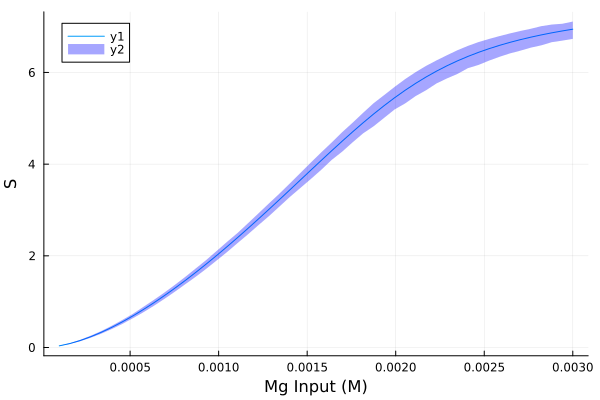

In [9]:
#Values in moles/L
Mginput_min = 0.1e-3
Mginput_max = 3e-3
PPiinput = 1e-3

nsamples = 2000#Number of mc samples for uncertainty
valueindex = 1#Number that we are interested in getting the model to predict (eg S = 1)
nevaluationpoints = 50#Resolution of our curve


#You dont have to change anything below this line
Mginputs = LinRange(Mginput_min,Mginput_max,nevaluationpoints)
S = zeros(nevaluationpoints)
S_lowerbound = zeros(nevaluationpoints)
S_upperbound = zeros(nevaluationpoints)

for (index,i) in enumerate(Mginputs)
    inputs = [i,PPiinput]
    (prediction, lower, upper) = supersaturationprediction(fittingmodel, pl, covariance, inputs,nsamples)
    S[index] = prediction[valueindex]
    S_lowerbound[index] = lower[valueindex]
    S_upperbound[index] = upper[valueindex]
end
plot(Mginputs,S,ylabel = "S", xlabel = "Mg Input (M)")
plot!(Mginputs, S_lowerbound, fillrange = S_upperbound, fillalpha = 0.35,alpha=0.0,color = :blue)

<h>Example 3: Plotting supersaturation as a function of PPi input (constant Mg input)<h>

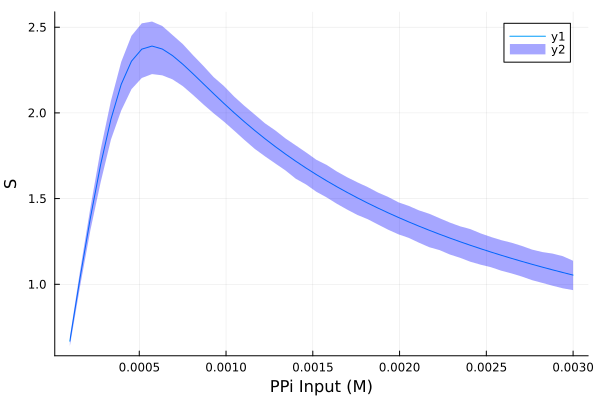

In [10]:
#Values in moles/L
PPiinput_min = 0.1e-3
PPiinput_max = 3e-3
Mginput = 1e-3

nsamples = 2000#Number of mc samples for uncertainty
valueindex = 1#Number that we are interested in getting the model to predict (eg S = 1)
nevaluationpoints = 50#Resolution of our curve

#You dont have to change anything below this line
PPiinputs = LinRange(Mginput_min,Mginput_max,nevaluationpoints)
S = zeros(nevaluationpoints)
S_lowerbound = zeros(nevaluationpoints)
S_upperbound = zeros(nevaluationpoints)

for (index,i) in enumerate(PPiinputs)
    inputs = [Mginput,i]
    (prediction, lower, upper) = supersaturationprediction(fittingmodel, pl, covariance, inputs,nsamples)
    S[index] = prediction[valueindex]
    S_lowerbound[index] = lower[valueindex]
    S_upperbound[index] = upper[valueindex]
end
plot(Mginputs,S,ylabel = "S", xlabel = "PPi Input (M)")
plot!(Mginputs, S_lowerbound, fillrange = S_upperbound, fillalpha = 0.35,alpha=0.0,color = :blue)

<h>Example 4: Phase Diagram of Mg, PPi input space<h>

In [11]:
#Values in moles/L
Mginput_min = 0.1e-3
Mginput_max = 5e-3
PPiinput_min = 0.1e-3
PPiinput_max = 5e-3

nsamples = 500#Number of mc samples for uncertainty
n_Mginputs = 25#Resolution of Mg input space
n_PPiinputs = 25#Resolution of PPi input space

Mginputs = LinRange(Mginput_min,Mginput_max,n_Mginputs)
PPiinputs = LinRange(PPiinput_min,PPiinput_max,n_PPiinputs)
supersaturation = zeros(n_Mginputs,n_PPiinputs)
soluble = zeros(n_Mginputs,n_PPiinputs)

for i in 1:n_Mginputs
    for j in 1:n_PPiinputs
        inputs = [Mginputs[i],PPiinputs[j]]
        (prediction, lower, upper) = supersaturationprediction(fittingmodel, pl, covariance, inputs, nsamples)
        supersaturation[i,j] = prediction[1]
        soluble[i,j] = sum(1 .<[prediction[1],lower[1],upper[1]])/3
    end
end

There are two ways to show this information. First we can plot supersaturation as a function of Mg and PPi input. 

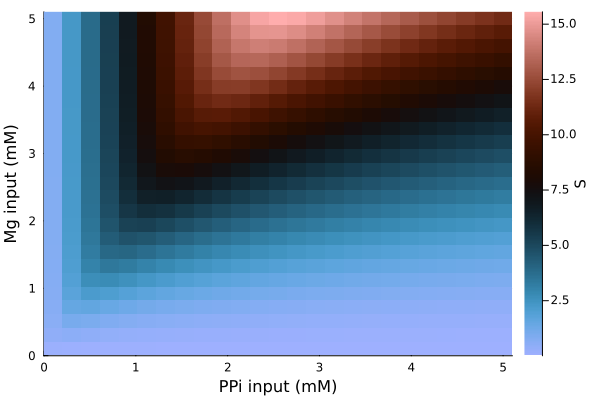

In [12]:
heatmap(1000*PPiinputs,1000*Mginputs,supersaturation,ylabel = "Mg input (mM)",xlabel = "PPi input (mM)",colorbar_title = "S",c = :berlin)

Second, we can plot a discrete value represeting whether S>1. This most closely resembles a "diagram". Basically, pink represents an input set that will result in solid formation, while blue represents an input set that is soluble. 

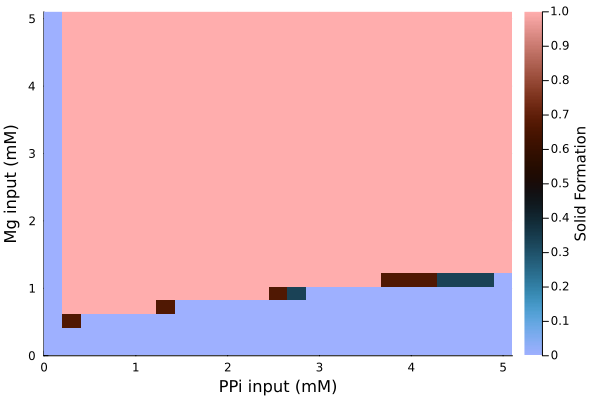

In [13]:
heatmap(1000*PPiinputs,1000*Mginputs,soluble,ylabel = "Mg input (mM)",xlabel = "PPi input (mM)",colorbar_title = "Solid Formation",c = :berlin)